In [1]:
import nibabel as nib
import numpy as np

# Đọc file
flair = nib.load('MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii')
seg = nib.load('MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii')

# Lấy dữ liệu numpy array
flair_data = flair.get_fdata()  # Shape: (240, 240, 155)
seg_data = seg.get_fdata()

# Lấy thông tin header
affine = flair.affine
header = flair.header

## Kiểm tra thông tin cơ bản

In [2]:
print("=" * 60)
print("THÔNG TIN ORIGINAL VOLUME")
print("=" * 60)
print(f"Shape: {flair_data.shape}")
print(f"Data type: {flair_data.dtype}")
print(f"Min value: {flair_data.min():.2f}")
print(f"Max value: {flair_data.max():.2f}")
print(f"Mean value: {flair_data.mean():.2f}")
print(f"Voxel dimensions: {header.get_zooms()}")

# ===== CROP ĐỂ LOẠI BỎ VÙNG ĐEN (BACKGROUND) =====
# Tìm bounding box của vùng não (non-zero voxels)
non_zero_mask = flair_data > 0

x_indices = np.where(np.any(non_zero_mask, axis=(1, 2)))[0]
y_indices = np.where(np.any(non_zero_mask, axis=(0, 2)))[0]
z_indices = np.where(np.any(non_zero_mask, axis=(0, 1)))[0]

x_min, x_max = x_indices[0], x_indices[-1]
y_min, y_max = y_indices[0], y_indices[-1]
z_min, z_max = z_indices[0], z_indices[-1]

# Crop data - loại bỏ vùng đen
flair_cropped = flair_data[x_min:x_max+1, y_min:y_max+1, z_min:z_max+1]
seg_cropped = seg_data[x_min:x_max+1, y_min:y_max+1, z_min:z_max+1]

print("\n" + "=" * 60)
print("SHAPE THẬT CỦA NÃO (SAU KHI CROP)")
print("=" * 60)
print(f"Bounding box:")
print(f"  X: [{x_min}:{x_max}] → Length: {x_max - x_min + 1} voxels")
print(f"  Y: [{y_min}:{y_max}] → Length: {y_max - y_min + 1} voxels")
print(f"  Z: [{z_min}:{z_max}] → Length: {z_max - z_min + 1} voxels")

print(f"\n So sánh kích thước:")
print(f"Original shape: {flair_data.shape}")
print(f"Brain-only shape: {flair_cropped.shape}")
print(f"Giảm: {(1 - np.prod(flair_cropped.shape)/np.prod(flair_data.shape))*100:.1f}% voxels")

# Kích thước vật lý thực tế
voxel_spacing = header.get_zooms()
brain_width = flair_cropped.shape[0] * voxel_spacing[0]
brain_height = flair_cropped.shape[1] * voxel_spacing[1]
brain_depth = flair_cropped.shape[2] * voxel_spacing[2]

print(f"\n KÍCH THƯỚC VẬT LÝ CỦA NÃO (mm):")
print(f"  Width:  {brain_width:.1f} mm ({brain_width/10:.1f} cm)")
print(f"  Height: {brain_height:.1f} mm ({brain_height/10:.1f} cm)")
print(f"  Depth:  {brain_depth:.1f} mm ({brain_depth/10:.1f} cm)")
print(f"  Thể tích: {(brain_width * brain_height * brain_depth)/1000:.1f} cm³")

print("\n" + "=" * 60)
print("THÔNG TIN SEGMENTATION (CROPPED)")
print("=" * 60)
print(f"Shape: {seg_cropped.shape}")
print(f"Data type: {seg_cropped.dtype}")
print(f"Unique labels: {np.unique(seg_cropped)}")

# Đếm số voxel cho mỗi label (trên cropped data)
for label in np.unique(seg_cropped):
    count = np.sum(seg_cropped == label)
    percent = (count / seg_cropped.size) * 100
    label_names = {0: "Background", 1: "NCR", 2: "Edema", 4: "Enhancing Tumor"}
    name = label_names.get(int(label), "Unknown")
    print(f"Label {int(label)} ({name}): {count:,} voxels ({percent:.2f}%)")

THÔNG TIN ORIGINAL VOLUME
Shape: (240, 240, 155)
Data type: float64
Min value: 0.00
Max value: 625.00
Mean value: 26.02
Voxel dimensions: (np.float32(1.0), np.float32(1.0), np.float32(1.0))

SHAPE THẬT CỦA NÃO (SAU KHI CROP)
Bounding box:
  X: [49:185] → Length: 137 voxels
  Y: [42:214] → Length: 173 voxels
  Z: [4:138] → Length: 135 voxels

 So sánh kích thước:
Original shape: (240, 240, 155)
Brain-only shape: (137, 173, 135)
Giảm: 64.2% voxels

 KÍCH THƯỚC VẬT LÝ CỦA NÃO (mm):
  Width:  137.0 mm (13.7 cm)
  Height: 173.0 mm (17.3 cm)
  Depth:  135.0 mm (13.5 cm)
  Thể tích: 3199.6 cm³

THÔNG TIN SEGMENTATION (CROPPED)
Shape: (137, 173, 135)
Data type: float64
Unique labels: [0. 1. 2. 4.]
Label 0 (Background): 2,987,656 voxels (93.37%)
Label 1 (NCR): 15,443 voxels (0.48%)
Label 2 (Edema): 168,794 voxels (5.28%)
Label 4 (Enhancing Tumor): 27,742 voxels (0.87%)


## So sánh Original vs Cropped (Trước và sau khi loại bỏ vùng đen)

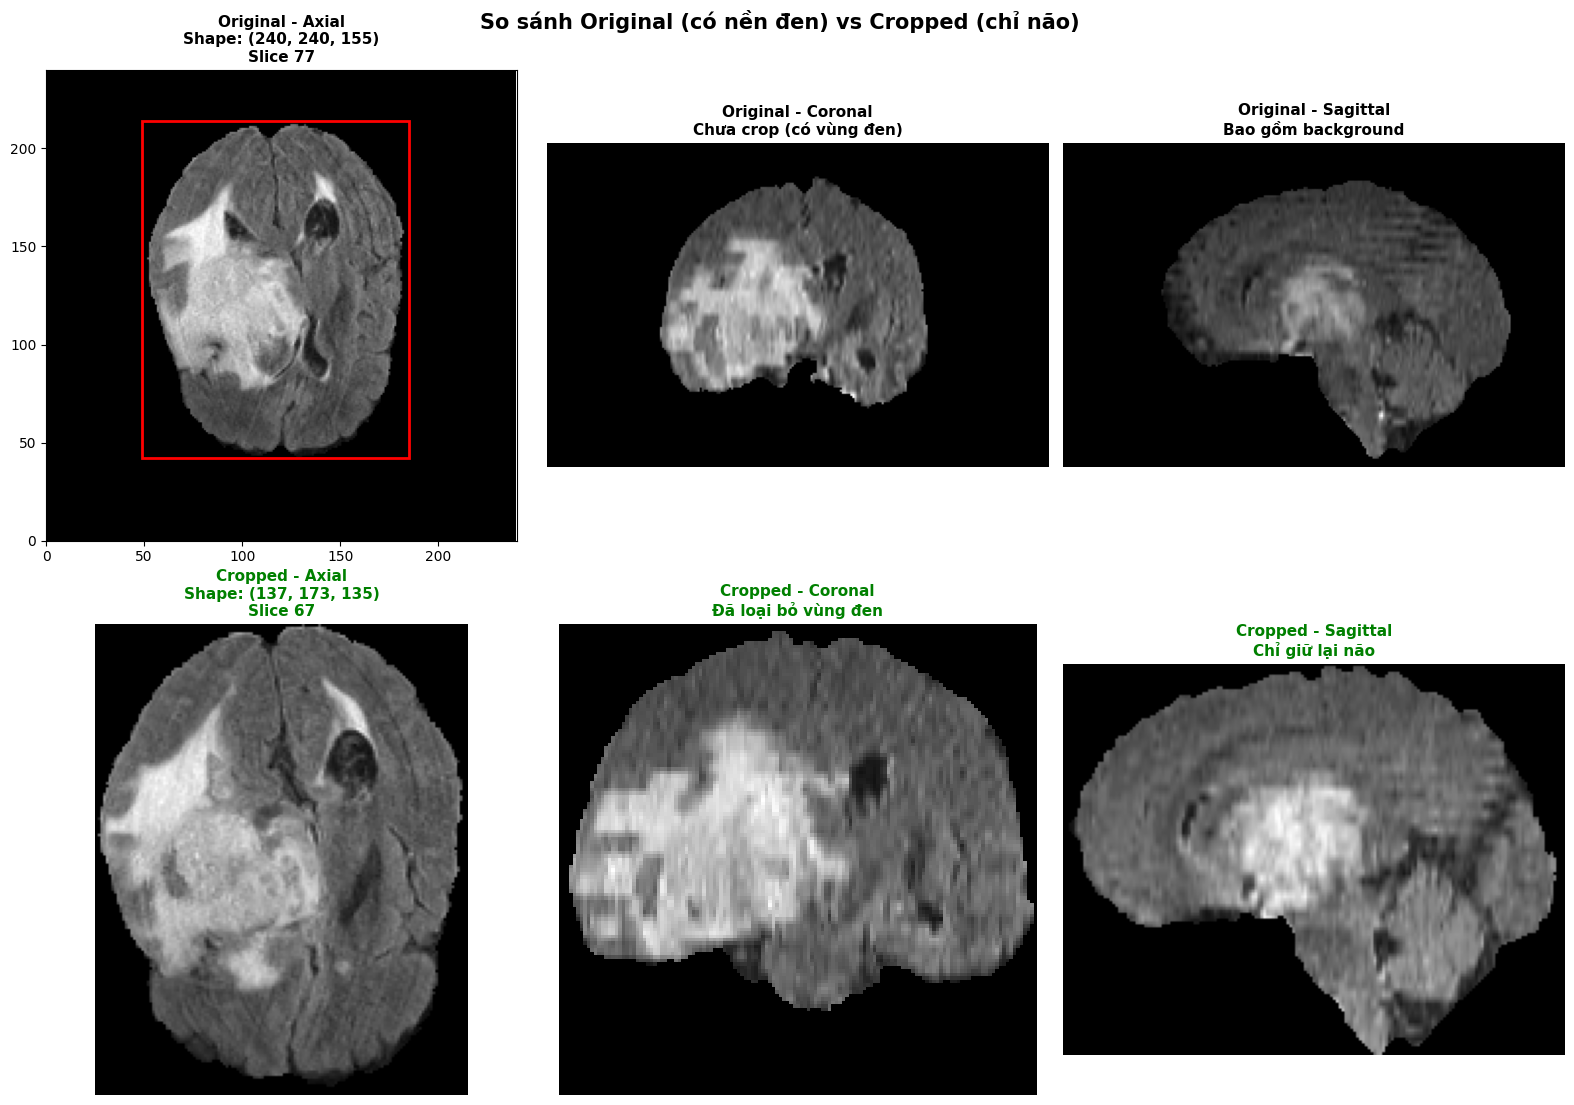


TÓNG TẮT SO SÁNH
                                         Original            Cropped
----------------------------------------------------------------------
Shape (X, Y, Z)                   (240, 240, 155)    (137, 173, 135)
Tổng số voxels                          8,928,000          3,199,635
Kích thước X (mm)                             240                137
Kích thước Y (mm)                             240                173
Kích thước Z (mm)                             155                135
----------------------------------------------------------------------

Giảm 64.2% voxels sau khi crop
Khung đỏ trong ảnh Original = Vùng não sẽ được giữ lại
Cropped = Chỉ giữ vùng trong khung đỏ, loại bỏ phần đen xung quanh


In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, axes = plt.subplots(2, 3, figsize=(16, 11))

# Chọn slice giữa cho original và cropped
original_slice_idx = flair_data.shape[2] // 2
cropped_slice_idx = flair_cropped.shape[2] // 2

# ===== HÀNG 1: ORIGINAL (Chưa crop) =====
# Axial view
axes[0, 0].imshow(flair_data[:, :, original_slice_idx].T, cmap='gray', origin='lower')
axes[0, 0].set_title(f'Original - Axial\nShape: {flair_data.shape}\nSlice {original_slice_idx}', 
                     fontsize=11, fontweight='bold')
# Vẽ bounding box của vùng não
rect = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, 
                         linewidth=2, edgecolor='red', facecolor='none')
axes[0, 0].add_patch(rect)
axes[0, 0].set_xlim(0, flair_data.shape[0])
axes[0, 0].set_ylim(0, flair_data.shape[1])
axes[0, 0].axis('on')
axes[0, 0].grid(False)

# Coronal view
axes[0, 1].imshow(flair_data[:, flair_data.shape[1]//2, :].T, cmap='gray', origin='lower')
axes[0, 1].set_title(f'Original - Coronal\nChưa crop (có vùng đen)', 
                     fontsize=11, fontweight='bold')
axes[0, 1].axis('off')

# Sagittal view
axes[0, 2].imshow(flair_data[flair_data.shape[0]//2, :, :].T, cmap='gray', origin='lower')
axes[0, 2].set_title(f'Original - Sagittal\nBao gồm background', 
                     fontsize=11, fontweight='bold')
axes[0, 2].axis('off')

# ===== HÀNG 2: CROPPED (Đã crop) =====
# Axial view
axes[1, 0].imshow(flair_cropped[:, :, cropped_slice_idx].T, cmap='gray', origin='lower')
axes[1, 0].set_title(f'Cropped - Axial\nShape: {flair_cropped.shape}\nSlice {cropped_slice_idx}', 
                     fontsize=11, fontweight='bold', color='green')
axes[1, 0].axis('off')

# Coronal view
axes[1, 1].imshow(flair_cropped[:, flair_cropped.shape[1]//2, :].T, cmap='gray', origin='lower')
axes[1, 1].set_title(f'Cropped - Coronal\nĐã loại bỏ vùng đen', 
                     fontsize=11, fontweight='bold', color='green')
axes[1, 1].axis('off')

# Sagittal view
axes[1, 2].imshow(flair_cropped[flair_cropped.shape[0]//2, :, :].T, cmap='gray', origin='lower')
axes[1, 2].set_title(f'Cropped - Sagittal\nChỉ giữ lại não', 
                     fontsize=11, fontweight='bold', color='green')
axes[1, 2].axis('off')

plt.tight_layout()
plt.suptitle('So sánh Original (có nền đen) vs Cropped (chỉ não)', 
             fontsize=15, fontweight='bold', y=1.00)
plt.show()

# In thông tin tóm tắt
print("\n" + "=" * 70)
print("TÓNG TẮT SO SÁNH")
print("=" * 70)
print(f"{'':30s} {'Original':>18s} {'Cropped':>18s}")
print("-" * 70)
print(f"{'Shape (X, Y, Z)':30s} {str(flair_data.shape):>18s} {str(flair_cropped.shape):>18s}")
print(f"{'Tổng số voxels':30s} {np.prod(flair_data.shape):>18,} {np.prod(flair_cropped.shape):>18,}")
print(f"{'Kích thước X (mm)':30s} {flair_data.shape[0]:>18.0f} {flair_cropped.shape[0]:>18.0f}")
print(f"{'Kích thước Y (mm)':30s} {flair_data.shape[1]:>18.0f} {flair_cropped.shape[1]:>18.0f}")
print(f"{'Kích thước Z (mm)':30s} {flair_data.shape[2]:>18.0f} {flair_cropped.shape[2]:>18.0f}")
print("-" * 70)
reduction = (1 - np.prod(flair_cropped.shape)/np.prod(flair_data.shape)) * 100
print(f"\nGiảm {reduction:.1f}% voxels sau khi crop")
print(f"Khung đỏ trong ảnh Original = Vùng não sẽ được giữ lại")
print(f"Cropped = Chỉ giữ vùng trong khung đỏ, loại bỏ phần đen xung quanh")

## Visualize MRI slices và segmentation

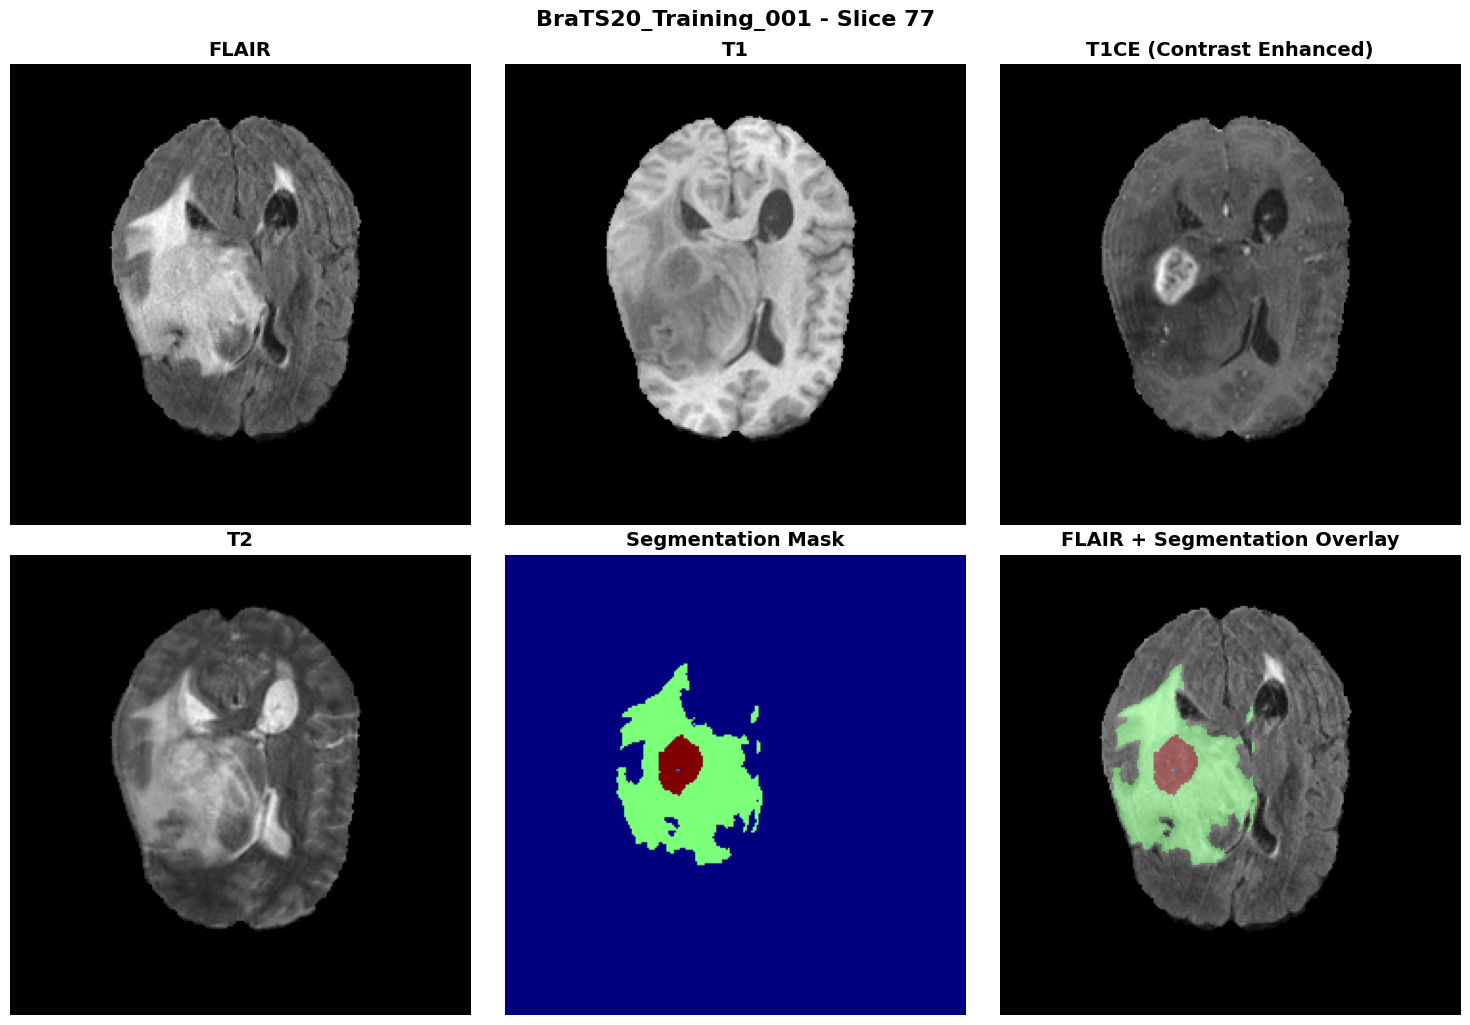

Đang hiển thị slice 77/155


In [4]:
import matplotlib.pyplot as plt

# Chọn slice ở giữa (trục axial)
slice_idx = flair_data.shape[2] // 2

# Đọc thêm các modality khác
t1 = nib.load('MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii')
t1ce = nib.load('MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii')
t2 = nib.load('MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii')

t1_data = t1.get_fdata()
t1ce_data = t1ce.get_fdata()
t2_data = t2.get_fdata()

# Vẽ tất cả 4 modalities và segmentation
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(flair_data[:, :, slice_idx].T, cmap='gray', origin='lower')
axes[0, 0].set_title('FLAIR', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(t1_data[:, :, slice_idx].T, cmap='gray', origin='lower')
axes[0, 1].set_title('T1', fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

axes[0, 2].imshow(t1ce_data[:, :, slice_idx].T, cmap='gray', origin='lower')
axes[0, 2].set_title('T1CE (Contrast Enhanced)', fontsize=14, fontweight='bold')
axes[0, 2].axis('off')

axes[1, 0].imshow(t2_data[:, :, slice_idx].T, cmap='gray', origin='lower')
axes[1, 0].set_title('T2', fontsize=14, fontweight='bold')
axes[1, 0].axis('off')

# Segmentation với colormap
seg_slice = seg_data[:, :, slice_idx].T
axes[1, 1].imshow(seg_slice, cmap='jet', origin='lower', vmin=0, vmax=4)
axes[1, 1].set_title('Segmentation Mask', fontsize=14, fontweight='bold')
axes[1, 1].axis('off')

# Overlay segmentation trên FLAIR
axes[1, 2].imshow(flair_data[:, :, slice_idx].T, cmap='gray', origin='lower')
masked_seg = np.ma.masked_where(seg_slice == 0, seg_slice)
axes[1, 2].imshow(masked_seg, cmap='jet', alpha=0.5, origin='lower', vmin=0, vmax=4)
axes[1, 2].set_title('FLAIR + Segmentation Overlay', fontsize=14, fontweight='bold')
axes[1, 2].axis('off')

plt.tight_layout()
plt.suptitle(f'BraTS20_Training_001 - Slice {slice_idx}', fontsize=16, fontweight='bold', y=1.02)
plt.show()

print(f"Đang hiển thị slice {slice_idx}/{flair_data.shape[2]}")

## Visualize 3D tumor regions

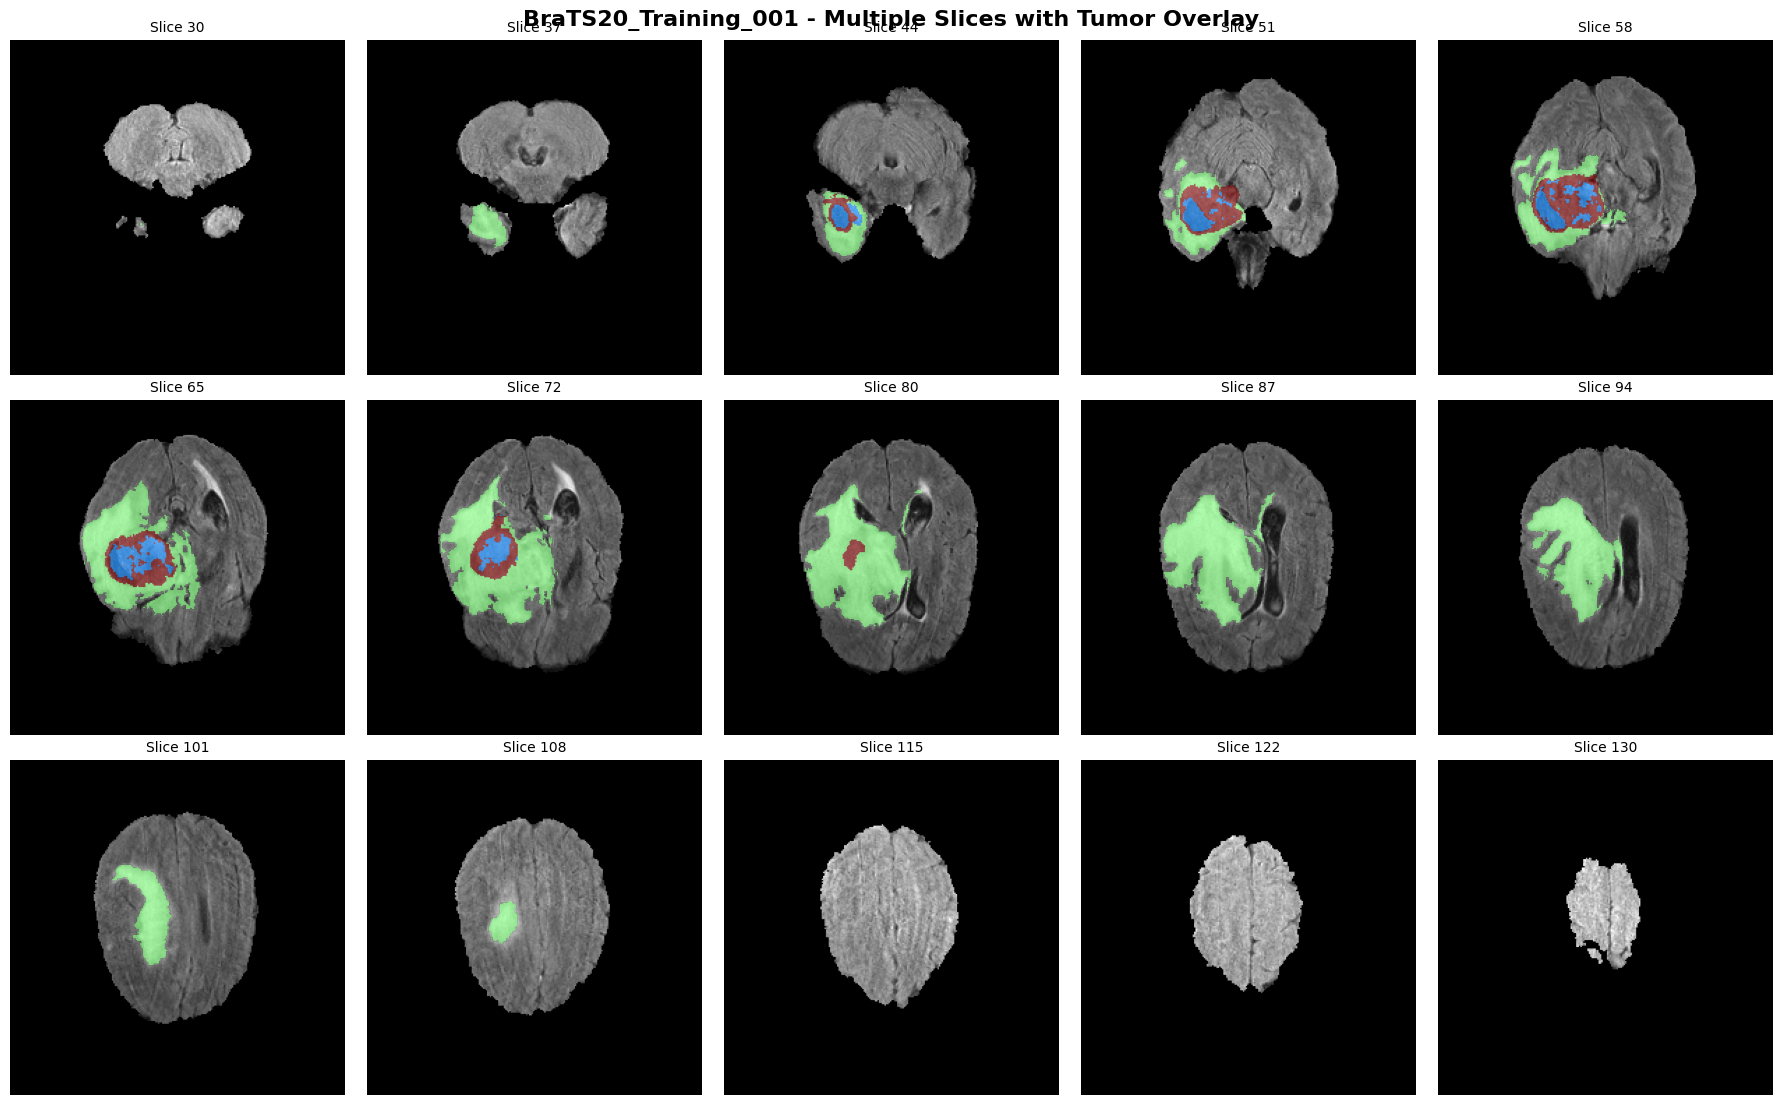


📊 Segmentation Labels:
  🔵 Label 0 (Background): Mô não bình thường
  🟡 Label 1 (NCR): Necrotic/Non-enhancing tumor
  🟢 Label 2 (ED): Edema (phù não)
  🔴 Label 4 (ET): Enhancing tumor


In [ ]:
# Hiển thị nhiều slices để thấy tumor trong 3D
fig, axes = plt.subplots(3, 5, figsize=(18, 11))

# Chọn 15 slices đều nhau
num_slices = 15
slice_indices = np.linspace(30, 130, num_slices, dtype=int)

for idx, slice_num in enumerate(slice_indices):
    row = idx // 5
    col = idx % 5
    
    # Hiển thị FLAIR với segmentation overlay
    axes[row, col].imshow(flair_data[:, :, slice_num].T, cmap='gray', origin='lower')
    
    # Overlay segmentation (chỉ vùng có tumor)
    seg_slice = seg_data[:, :, slice_num].T
    masked_seg = np.ma.masked_where(seg_slice == 0, seg_slice)
    axes[row, col].imshow(masked_seg, cmap='jet', alpha=0.6, origin='lower', vmin=0, vmax=4)
    
    axes[row, col].set_title(f'Slice {slice_num}', fontsize=10)
    axes[row, col].axis('off')

plt.tight_layout()
plt.suptitle('BraTS20_Training_001 - Multiple Slices with Tumor Overlay', 
             fontsize=16, fontweight='bold', y=1.00)
plt.show()

# Legend cho segmentation labels
print("\nSegmentation Labels:")
print("  🔵 Label 0 (Background): Mô não bình thường")
print("  🟡 Label 1 (NCR): Necrotic/Non-enhancing tumor")
print("  🟢 Label 2 (ED): Edema (phù não)")
print("  🔴 Label 4 (ET): Enhancing tumor")